In [ ]:
%load_ext autoreload
%autoreload 2

# Homework 7
Chris Dailey

christopher.dailey@gmail.com

## HW 7.0
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

In [127]:
%%writefile MRJobGraph1.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re, sys


class MRJobPrepGraphData(MRJob):
    # run before the mapper processes any input
    
    def configure_options(self):
        super(MRJobPrepGraphData, self).configure_options()
        self.add_passthrough_option("--startnode", default="1", type=str)
        
    def label_dataset(self, _, line):
        
        source_node_id = int(self.options.startnode)
        # Read dataset and add labels and distances
        splits = line.split("\t")
        node_id = int(splits[0])
        edges = eval(splits[1])
        if (node_id == source_node_id):
            yield str(node_id), str([int(x) for x in edges.keys()]) + "|0|[]|Q"
        else:
            yield str(node_id), str([int(x) for x in edges.keys()]) + "|"+str(sys.maxint)+"|[]|U"
            
    def steps(self):
        return [MRStep(mapper=self.label_dataset)]

class MRJobGraph1(MRJob):
    
    def configure_options(self):
        super(MRJobGraph1, self).configure_options()
        self.add_passthrough_option("--endnode", default=None, type=str)

    def push_frontier(self, _, line):
        self.increment_counter('states', 'Q', 0)
        splits = line.split('\t')
        key = int(splits[0])
        value = splits[1]
        value_splits = value.split('|')
        edges = eval(value_splits[0])
        distance = int(value_splits[1])
        path = eval(value_splits[2])
        status = value_splits[3]
        if status == 'Q':
            path.append(key)
            for edge in edges:
                yield int(edge), '[]|'+str(distance + 1) + '|' + str(path) + '|Q'
            status = 'V'
        if status == 'U' or status == 'V':
            yield int(key), str(edges) + '|' + str(distance) + '|' + str(path) + '|' + status
    
    def combine_records(self, key, values):
        self.increment_counter("completionstatus", "endreached", 0)
        final_edges = []
        final_distance = sys.maxint
        final_status = '?'
        final_path = []
        for value in values:
            value_splits = value.split('|')
            edges = eval(value_splits[0])
            distance = int(value_splits[1])
            path = eval(value_splits[2])
            status = value_splits[3]
            final_edges = final_edges + edges
            final_distance = min(final_distance, distance)
            if final_status == '?' or final_status == 'U':
                final_status = status
                if status == 'Q':
                    self.increment_counter('states', 'Q', 1)
                if status == 'Q' or status == 'V':
                    final_path = path
#             if final_status == 'U' and len(path) > len(final_path):
#                 final_path = path
        if self.options.endnode != None and int(self.options.endnode) == key and final_status == "V":
            self.increment_counter("completionstatus", "endreached", 1)
        yield key, str(final_edges) + '|' + str(final_distance) + '|' +  str(final_path) + '|' + final_status
        
        
    def passthrough(self, key, value):
        yield key, value
    

    
    def steps(self):
        return [#MRStep(mapper=self.passthrough)
                MRStep(mapper=self.push_frontier,
                       reducer=self.combine_records)
               ]
    

    
if __name__ == '__main__':
    MRJobGraph1.run()

Overwriting MRJobGraph1.py


In [132]:
from numpy import random,array
from MRJobGraph1 import MRJobGraph1, MRJobPrepGraphData

def SSSP(filename, source_node, end_node):
    prep_data = MRJobPrepGraphData(args=[filename, '--no-strict-protocol', "--startnode", source_node])
    with prep_data.make_runner() as runner:
        prepped_data = open("prepped_data0.txt", 'w')
        runner.run()
        for line in runner.stream_output():
            key, value = prep_data.parse_output_line(line)
            print key + "\t" + value
            prepped_data.write(key + '\t' + value + '\n')
        prepped_data.close()


    print "\n\nSecond Job:\n\n"

    iteration = 1
    while(True):
        mr_job = MRJobGraph1(args=['prepped_data' + str((iteration-1)%2) + '.txt', '--no-strict-protocol', "--endnode", end_node])
        with mr_job.make_runner() as runner: 
            runner.run()
            filename = "prepped_data" + str(iteration%2) + ".txt"
            prepped_data = open(filename, 'w')
            #no output yet
            for line in runner.stream_output():
                key, value = mr_job.parse_output_line(line)
                print str(key) + "\t" + value
                prepped_data.write(str(key) + '\t' + value + '\n')
            prepped_data.close()
            current_counters = runner.counters()
            print current_counters
            if current_counters[0]['states']['Q'] == 0:
                break
            if current_counters[0]['completionstatus']['endreached'] != 0:
                break
            
            iteration += 1
    print "Iterations: " + str(iteration)

In [135]:
SSSP("directed_toy.txt","1", "5")

1	[2, 6]|0|[]|Q
2	[1, 3, 4]|9223372036854775807|[]|U
3	[2, 4]|9223372036854775807|[]|U
4	[2, 5]|9223372036854775807|[]|U
5	[1, 2, 4]|9223372036854775807|[]|U


Second Job:


1	[2, 6]|0|[1]|V
2	[1, 3, 4]|1|[1]|Q
3	[2, 4]|9223372036854775807|[]|U
4	[2, 5]|9223372036854775807|[]|U
5	[1, 2, 4]|9223372036854775807|[]|U
6	[]|1|[1]|Q
[{'states': {'Q': 2}, 'completionstatus': {'endreached': 0}}]
1	[2, 6]|0|[1]|V
2	[1, 3, 4]|1|[1, 2]|V
3	[2, 4]|2|[1, 2]|Q
4	[2, 5]|2|[1, 2]|Q
5	[1, 2, 4]|9223372036854775807|[]|U
6	[]|1|[1, 6]|V
[{'states': {'Q': 2}, 'completionstatus': {'endreached': 0}}]
1	[2, 6]|0|[1]|V
2	[1, 3, 4]|1|[1, 2]|V
3	[2, 4]|2|[1, 2, 3]|V
4	[2, 5]|2|[1, 2, 4]|V
5	[1, 2, 4]|3|[1, 2, 4]|Q
6	[]|1|[1, 6]|V
[{'states': {'Q': 1}, 'completionstatus': {'endreached': 0}}]
1	[2, 6]|0|[1]|V
2	[1, 3, 4]|1|[1, 2]|V
3	[2, 4]|2|[1, 2, 3]|V
4	[2, 5]|2|[1, 2, 4]|V
5	[1, 2, 4]|3|[1, 2, 4, 5]|V
6	[]|1|[1, 6]|V
[{'states': {'Q': 0}, 'completionstatus': {'endreached': 1}}]
Iterations: 4


## Main Dataset 1
In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt
s3://ucb-mids-mls-networks/synNet/indices.txt
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


## HW 7.1

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [138]:
!head ./Data/synNet/synNet.txt

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
6	{'5': 1}
7	{'8': 1, '9': 1}
8	{'7': 1, '9': 1}
9	{'7': 1, '8': 1, '124': 1, '1316': 1}
10	{'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}


In [139]:
!wc -l ./Data/synNet/synNet.txt

8271 ./Data/synNet/synNet.txt


In [137]:
!head ./Data/synNet/indices.txt

A	1
As	2
a	3
as	4
AB	5
abdominal	6
AD	7
ad	8
advertising	9
AIDS	10


In [ ]:
!wc -l ./Data/synNet/indices.txt

### Number of nodes

In [191]:
%%writefile MRJobGraph71.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re, sys

class MRJobGraph71a(MRJob):
    
    def count_nodes(self, _, line):
        yield None, 1
        
    def combine_counts(self, key, values):
        yield None, sum(values)
    
    def steps(self):
        return [#MRStep(mapper=self.passthrough)
                MRStep(mapper=self.count_nodes,
                       combiner=self.combine_counts,
                       reducer=self.combine_counts)
               ]
    
class MRJobGraph71b(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        for key, value in links.items():
            yield None, 1
            
    def sum_links(self, key, values):
        yield None, sum(values)
        
        
    def steps(self):
        return [
                MRStep(mapper=self.count_links,
                      combiner=self.sum_links,
                      reducer=self.sum_links)
                ]
    
class MRJobGraph71c(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        yield len(links), 1
        
    def sum_link_counts(self, key, values):
        yield int(key), sum(values)
        
    def steps(self):
        return [MRStep(
                    mapper=self.count_links,
                    combiner=self.sum_link_counts,
                    reducer=self.sum_link_counts,
                jobconf = {
                    
                }
                )
        ]
    
    
class MRJobGraph71d(MRJob):
    
    def count_links(self, _, line):
        splits = line.split('\t')
        links = eval(splits[1])
        yield None, (1, len(links))
        
        
    def average_links(self, _, values):
        count = 0
        total = 0
        for x, y in values:
            count += x
            total += y
        yield None, 1.0*total/count
        
    def steps(self):
        return [MRStep(
                    mapper=self.count_links,
                    reducer=self.average_links
            )]

    
if __name__ == '__main__':
    MRJobGraph71a.run()

Overwriting MRJobGraph71.py


In [163]:
from MRJobGraph71 import MRJobGraph71a

mr_job = MRJobGraph71a(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

8271


### Number of links

In [165]:
from MRJobGraph71 import MRJobGraph71b

mr_job = MRJobGraph71b(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

61134


### Degree distribution

In [186]:
from MRJobGraph71 import MRJobGraph71c
import matplotlib.pyplot as plt

keys = []
values = []

mr_job = MRJobGraph71c(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        keys.append(key)
        values.append(int(value))

In [187]:
%matplotlib inline

<Container object of 83 artists>

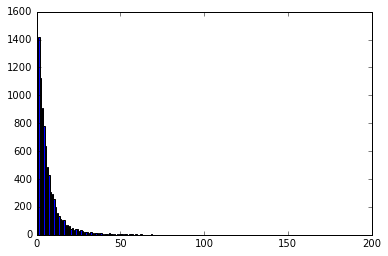

In [188]:
plt.bar(keys, values)

### Average links

In [192]:
from MRJobGraph71 import MRJobGraph71d

mr_job = MRJobGraph71d(args=['./Data/synNet/synNet.txt', '--no-strict-protocol'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        key, value = mr_job.parse_output_line(line)
        print value

7.39136742836


## HW 7.2
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).